In [1]:
!nvidia-smi

Tue Sep  5 00:01:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Setup

In [2]:
# !pip install -q -U sentence-transformers
# !pip install -q -U 'google-cloud-bigquery[bqstorage,pandas]'
# !pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com

### Librerias

In [157]:
import os
import torch
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cudf
from cuml import PCA, DBSCAN
from cuml.manifold import UMAP
from cuml.feature_extraction.text import TfidfVectorizer

from google.cloud.bigquery import Client
from google.oauth2.service_account import Credentials

from sentence_transformers import SentenceTransformer
from tqdm import tqdm

plt.style.use("ggplot")

### Variables

In [4]:
# BigQuery Variables
SERVICE_ACC_FILE="/content/valid-dragon-397303-a396a9a99124.json"
PROJECT_ID="valid-dragon-397303"

# Seed
SEED=1399

In [5]:
try:
    client = Client()
    client.query("SELECT 1 AS NUM")
except Exception as e:
    print(e)
    CREDENTIALS = Credentials.from_service_account_file(SERVICE_ACC_FILE)
    client = Client(project=PROJECT_ID, credentials=CREDENTIALS)

### Dataset

#### Carga de datos

Como el dataset original tiene mas de 130 millones de reviews, para esta primera entrega se utilizaran unicamente los datos relacionados a la categoria de videojuegos.

In [6]:
%%time
# Se traen los datos desde BigQuery
QUERY = (
    "SELECT * "
    "FROM `valid-dragon-397303.amazon_reviews.modeling_data` "
    "WHERE first_category_item = 'Video Games';"
)
job = client.query(QUERY)
data = job.to_dataframe()

CPU times: user 3.33 s, sys: 1.47 s, total: 4.8 s
Wall time: 6.32 s


#### Inspeccionar el dataset

In [7]:
# Se inspeccionan las primeras filas del dataset
data.head()

,review,brand,first_category_item
0,Perfect,BR,Video Games
1,one of the best rpg series ever... now all tog...,THQ,Video Games
2,was defective and had to be taken to be repaired.,Sony,Video Games
3,I got this model PS3 (40Gb 2 USB) in November....,Sony,Video Games
4,This is a pretty good game\nPROS:\nA GREAT TIT...,Atari,Video Games


In [8]:
# Se verifica la estructura de los datos
print(f"Filas: [{data.shape[0]}], Columnas [{data.shape[1]}]")

Filas: [1722888], Columnas [3]


In [9]:
# Se verifican los tipos de datos
data.dtypes.to_frame().T

,review,brand,first_category_item
0,object,object,object


- El conjunto de datos tiene 1.722.888 filas, de las cuales, cada una corresponde a un review diferente a un objeto dentro de la categoria de video juegos de Amazon.
- El conjunto de datos tiene 3 columnas: `review` que corresponde al review del objeto, `brand` que corresponde a la marca del objeto y `first_category_item` que corresponde a la categoria del objeto.

#### Descripción de los datos

In [10]:
data.describe()

,review,brand,first_category_item
count,1722888,1722888,1722888
unique,1281247,5839,1
top,good,by\n \n Nintendo,Video Games
freq,3663,142373,1722888


- Hay 1,281,247 reseñas distintas, siendo "good" la más repetida con 3,663 ocasiones.
- Existen 5,839 marcas diferentes de videojuegos. Además, se removerá el string "by \n \n " para hacer la marca más comprensible.
- Solo hay una categoría, ya que únicamente estamos trabajando con videojuegos.

In [11]:
data["brand"] = data["brand"]\
    .str.replace("by", "", regex=False)\
    .str.replace("\n", "", regex=False)\
    .str.strip()

<Axes: title={'center': 'Distribucion de reviews por marca\ntop 20'}, xlabel='%', ylabel='Marca'>

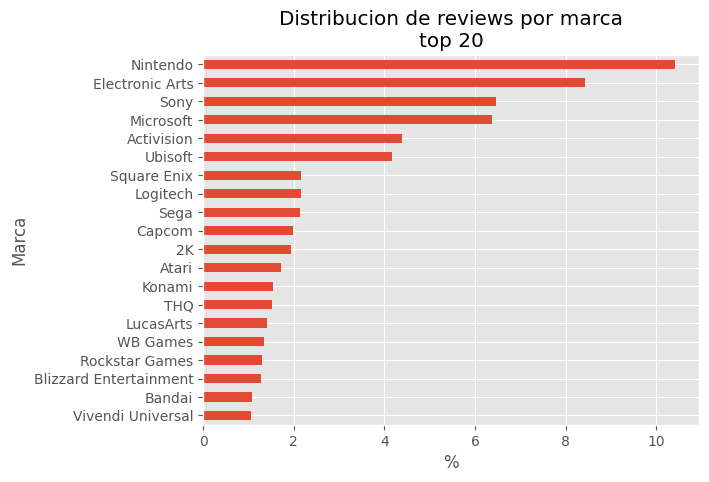

In [12]:
(data["brand"].value_counts(True).nlargest(20) * 100).sort_values()\
    .plot(kind="barh", title="Distribucion de reviews por marca\ntop 20", xlabel="%", ylabel="Marca")

- Entre Nintendo, EA, Sony, Microsoft y Activision se encuentra el 30% de los datos.
- Las demás marcas representan entre un 1% y 2% de los datos.

<Axes: title={'center': 'Distribucion de longitud de reviews'}, ylabel='Frequency'>

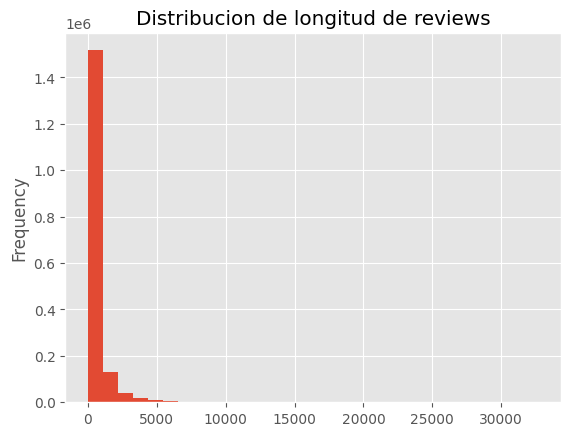

In [13]:
data["review"].str.len()\
    .plot(kind="hist", bins=30, title="Distribucion de longitud de reviews", xlabel="Longitud de la review", ylabel="Numero de Reviews")

In [14]:
data["review"].str.len().describe().to_frame().round(2)

,review
count,1722888.00
mean,511.02
std,919.50
min,1.00
25%,96.00
50%,205.00
75%,547.00
max,32721.00


- En promedio, las reseñas tienen 500 caracteres. Además, el 75% de los datos cuenta con aproximadamente 550 caracteres o menos.
- Hay reseñas con una longitud fuera de lo común; la más larga alcanza los 32,721 caracteres.

### Modelado

#### Embeddings de las reviews

Para usar las reseñas como entrada en algoritmos no supervisados, necesitamos convertir esos textos en una forma numérica, conocida como "embeddings". Para hacer esto, vamos a usar el modelo `all-distilroberta-v1`. Este modelo es una versión "destilada" (más ligera y rápida, pero casi igual de precisa) de RoBERTa, y ha sido adaptado específicamente para este tipo de tareas. El modelo convierte los párrafos en vectores en un espacio de 768 dimensiones. Además, es importante saber que la longitud máxima que el modelo puede manejar es de 512 caracteres. Esto encaja bastante bien con las características de nuestro conjunto de datos. Si alguna reseña tiene más de 512 caracteres, se cortará para ajustarse a este límite.Para usar las reseñas como entrada en algoritmos no supervisados, necesitamos convertir esos textos en una forma numérica, conocida como "embeddings". Para hacer esto, vamos a usar el modelo all-distilroberta-v1. Este modelo es una versión "destilada" (más ligera y rápida, pero casi igual de precisa) de RoBERTa, y ha sido adaptado específicamente para este tipo de tareas. El modelo convierte los párrafos en vectores en un espacio de 768 dimensiones. Además, es importante saber que la longitud máxima que el modelo puede manejar es de 512 caracteres. Esto encaja bastante bien con las características de nuestro conjunto de datos. Si alguna reseña tiene más de 512 tokens, se cortará para ajustarse a este límite.

In [15]:
# Se carga el modelo
MODEL_NAME = "sentence-transformers/all-distilroberta-v1"
model = SentenceTransformer(MODEL_NAME, device="cuda")

In [16]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [17]:
%%time
embeddings = model.encode(
    sentences=data["review"].to_numpy(),
    batch_size=128,
    device="cuda",
    convert_to_numpy=True,
    show_progress_bar=True
)

Batches:   0%|          | 0/13461 [00:00<?, ?it/s]

CPU times: user 30min 3s, sys: 24min 16s, total: 54min 20s
Wall time: 37min 26s


In [18]:
embeddings.shape

(1722888, 768)

In [19]:
type(embeddings[0])

numpy.ndarray

In [26]:
# Pasamos los embeddings a la GPU para no ocupar toda la memoria de la CPU.
embeddings = torch.from_numpy(embeddings).to("cuda")

In [30]:
type(embeddings)

torch.Tensor

### Reduccion de dimensionalidad

Una vez obtenidos los embeddings, estos se pueden utilizar en algoritmos no supervisados. Sin embargo, dado que tienen 768 dimensiones, encontrar clusters de reseñas se vuelve complicado. Por esta razón, aplicaremos una técnica de reducción de dimensionalidad.

#### PCA

In [44]:
%%time
dim_model = PCA(n_components=200, random_state=1399, svd_solver="full")
dim_model.fit(embeddings)

CPU times: user 47.2 ms, sys: 240 ms, total: 287 ms
Wall time: 284 ms


PCA()

Text(0.5, 0, 'Numero de componentes')

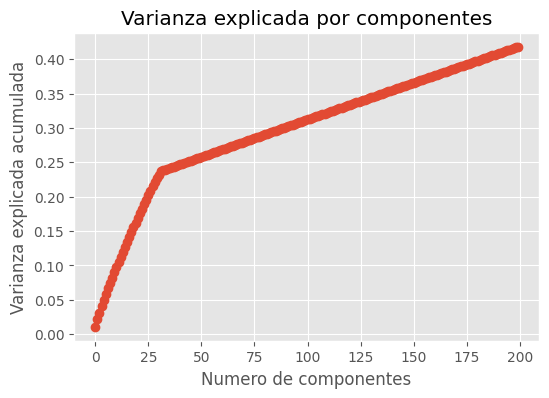

In [52]:
plt.figure(figsize = (6, 4))
plt.plot(range(200), dim_model.explained_variance_ratio_.cumsum().get(), marker="o", linestyle="--")
plt.title("Varianza explicada por componentes")
plt.ylabel("Varianza explicada acumulada")
plt.xlabel("Numero de componentes")

Los resultados de PCA no son muy buenos ya que con 200 componentes aun no se llega al 50% de varianza explicada. Por esta razon se exploraran otras tecnicas.

#### UMAP

UMAP (Aproximación y Proyección de Variedad Uniforme) es otra tecnica de reduccion de dimensionalidad la cual transforma este conjunto de datos en uno más pequeño y manejable, con menos dimensiones, mientras mantiene las relaciones clave entre los puntos de datos. Se usara UMAP con `n_neighbors=15`, lo que indica que cada punto considerará a 15 vecinos cercanos para mantener las relaciones locales en el nuevo espacio de menor dimensión. Con `n_components=2`, se busca reducir los datos a un espacio de 2 dimensiones. Ademas, se usa `metric="cosine"` porque estamos más interesados en la orientación que en la magnitud de los vectores. La similitud del coseno es especialmente útil para datos de alta dimensión y dispersos como los embeddings de texto, ya que mide el ángulo entre vectores, lo que a menudo es más informativo que la distancia euclidiana en estos contextos. 

In [48]:
%%time
dim_model_2 = UMAP(n_neighbors=15, n_components=2, metric="cosine").fit(embeddings)

CPU times: user 1min 15s, sys: 5min 8s, total: 6min 23s
Wall time: 6min 18s


In [49]:
truncated_embeddings = dim_model_2.transform(embeddings)

In [53]:
truncated_embeddings.shape

(1722888, 2)

#### Visualizar embeddings reducidos

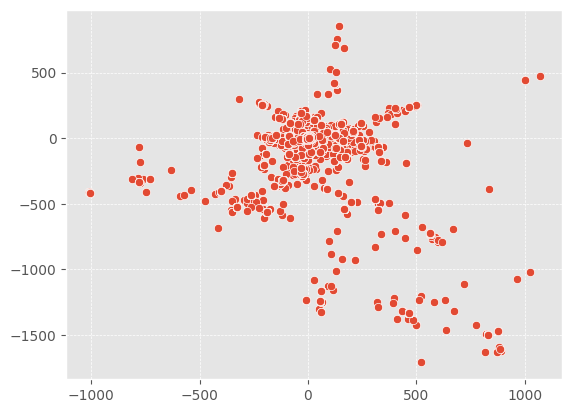

In [111]:
fig, ax = plt.subplots()
sns.scatterplot(x=truncated_embeddings[:, 0].get(), y=truncated_embeddings[:, 1].get())
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

In [59]:
# Se guardan los embeddings en el dataframe original
data["x"] = truncated_embeddings[:, 0].get()
data["y"] = truncated_embeddings[:, 1].get()

### Cluster
Una vez reducida la dimension, se procede a utilizar DBSCAN para detectar posibles agrupaciones de reseñas.

#### DBSCAN

In [187]:
%%time
cluster = DBSCAN(metric="cosine", min_samples=4, eps=.2)
cluster.fit(truncated_embeddings)

In [126]:
data["cluster"] = cluster.labels_.get()

In [188]:
# Numero de clusters
data["cluster"].nunique()

117

In [189]:
data["cluster"].value_counts(True)

0      0.975991
26     0.001406
36     0.001308
22     0.001221
13     0.001129
         ...   
88     0.000006
107    0.000006
108    0.000006
113    0.000006
114    0.000006
Name: cluster, Length: 117, dtype: float64

#### Visualizacion de los clusters

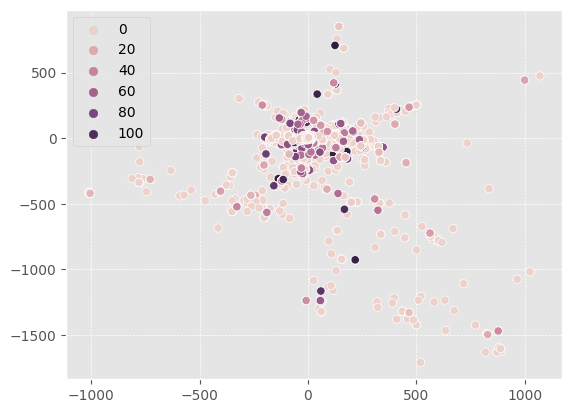

In [128]:
fig, ax = plt.subplots()
sns.scatterplot(x=truncated_embeddings[:, 0].get(), y=truncated_embeddings[:, 1].get(), hue=cluster.labels_.get())
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

In [190]:
data.groupby(["cluster"], as_index = False).agg({"review": " ".join})

,cluster,review
0,-1,Perfect good game good good game Excellent. Gr...
1,0,one of the best rpg series ever... now all tog...
2,1,Excelent Excelent Excelent Excelent Excelent E...
3,2,Excellent Excellent Excellent Excellent Excell...
4,3,Thank you Thank you Thank you Thank you thank ...
...,...,...
112,111,Perfect Perfect Perfect Perfect Perfect Perfec...
113,112,good good good good good good good good good g...
114,113,good game good game good game good game good g...
115,114,Works great Works great Works great Works grea...


DBSCAN agrupó los datos de tal manera que en su mayoría separa las reseñas de una sola palabra en diferentes clústeres, mientras que agrupa las reseñas más extensas en un único clúster. Este comportamiento sugiere que el espacio métrico de DBSCAN podría ser sensible a la longitud de la reseña, lo que lleva a una agrupación menos matizada del texto más largo. Dado que el algoritmo ha resultado en este tipo de agrupación sesgada, se necesita una exploración y ajuste adicional de los hiperparámetros `eps` y `min_samples`, para lograr un agrupamiento más equilibrado y significativo de los datos.